# Neural Network
### This task uses a neural network to perform the classification task on the Adult dataset. Feedforward Neural Network (FFN) is used in this task.
Let's import the clean data:

In [1]:
import pandas as pd

# Read data 
df = pd.read_csv('data/data_train.csv', header=0)

# print(X.head())

## Exporatory data analysis:
Second, let's do some Exploratory data analysis：

We can check the proportion of positive and negative samples

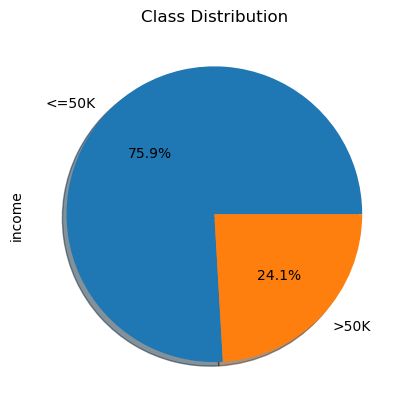

In [2]:
import matplotlib.pyplot as plt

# Using pie charts to count the number and proportion of positive and negative samples
count = df.iloc[:,-1].value_counts()

count.plot(kind='pie', labels=['<=50K', '>50K'], autopct='%1.1f%%', shadow=True)
plt.title('Class Distribution')
plt.show()

Then, let's do the bivariate Analysis:

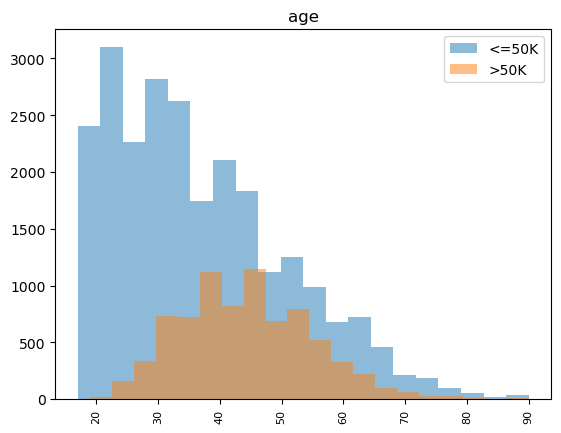

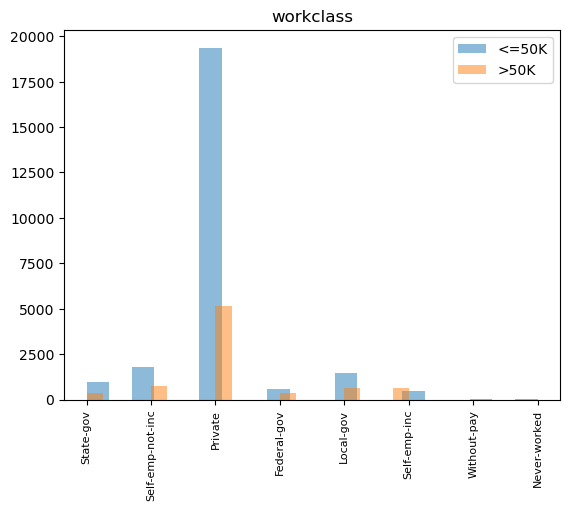

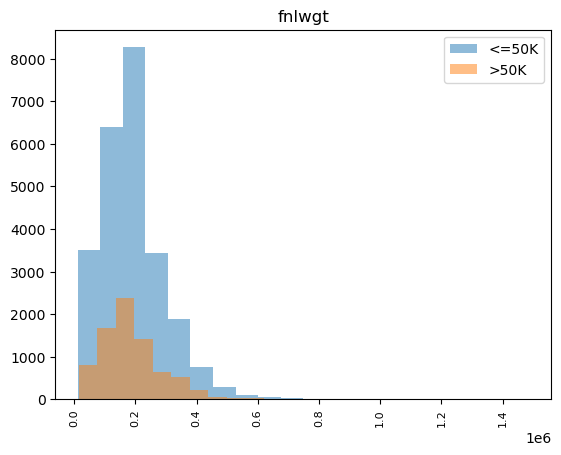

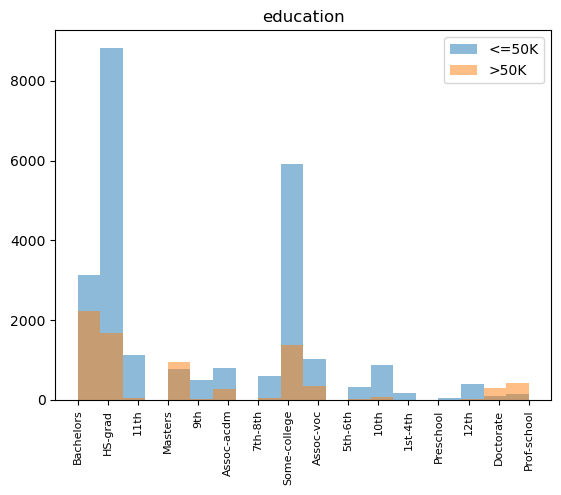

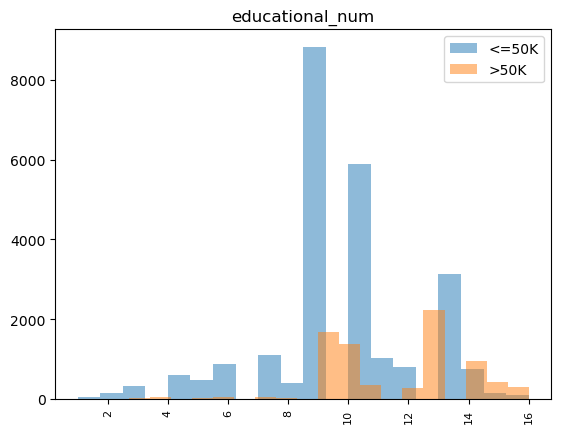

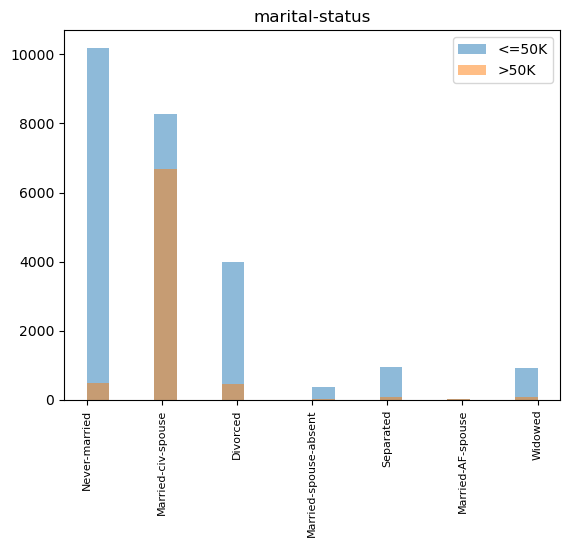

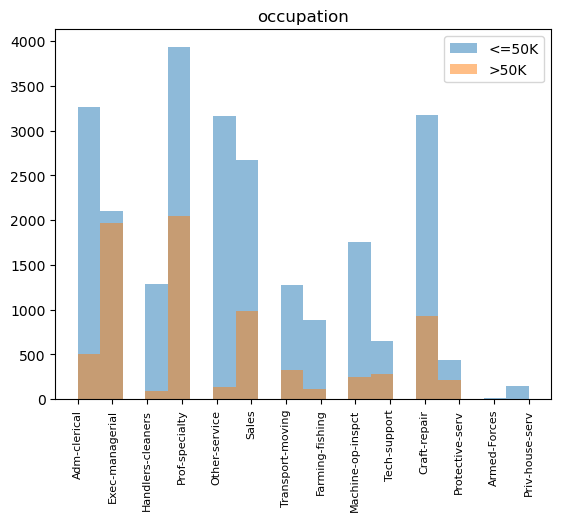

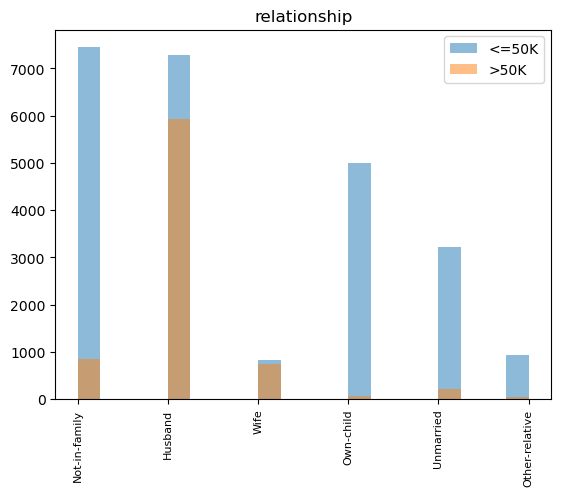

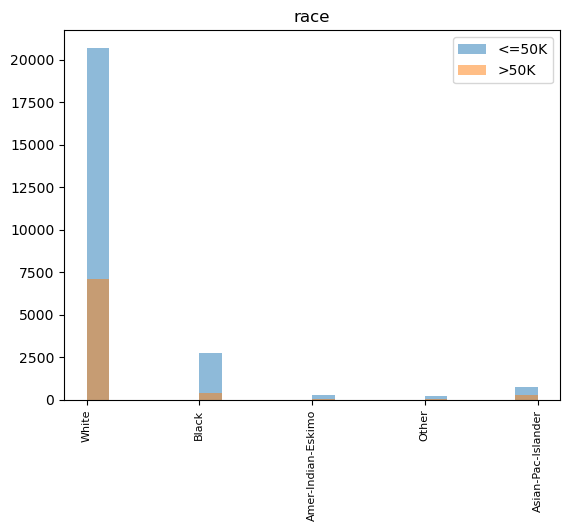

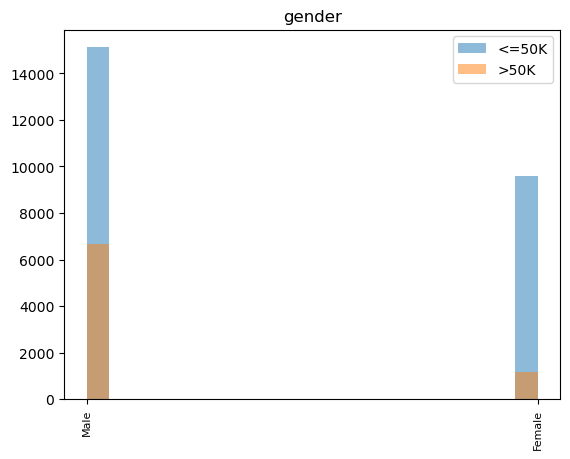

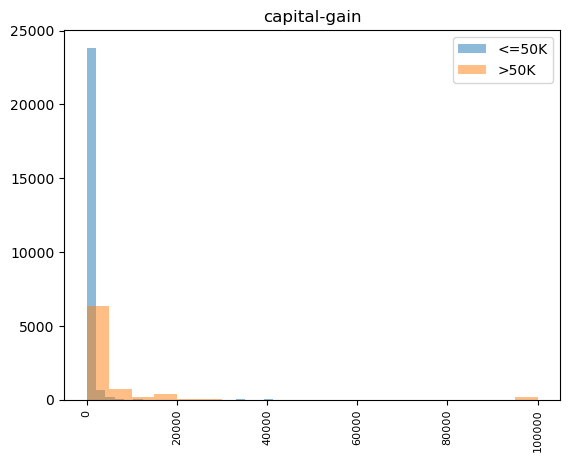

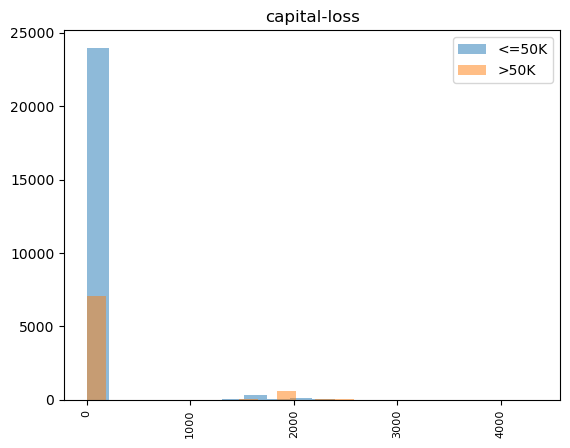

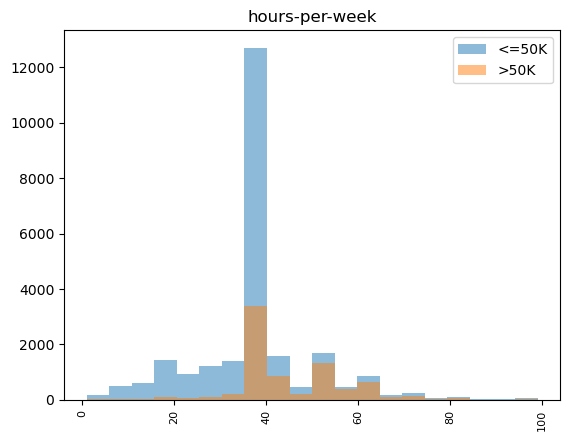

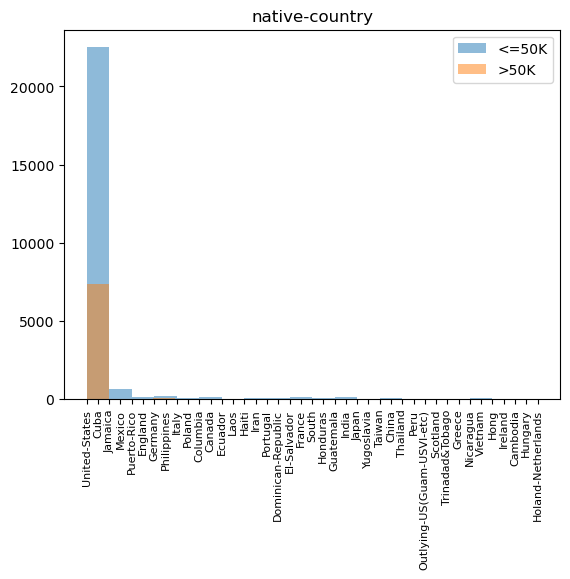

In [3]:
# Plot the histogram of each feature：
for feature in df.columns:
    if feature == 'income':
        continue
    plt.hist(df[df['income'] == 0][feature], bins=20, alpha=0.5, label='<=50K')
    plt.hist(df[df['income'] == 1][feature], bins=20,alpha=0.5, label='>50K')
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.xticks(rotation=90, fontsize=8)
    plt.show()


And we can also calculate the corrilations of the numerical features, and then reduce some fetures with higher corralation

C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_26568\2172967636.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


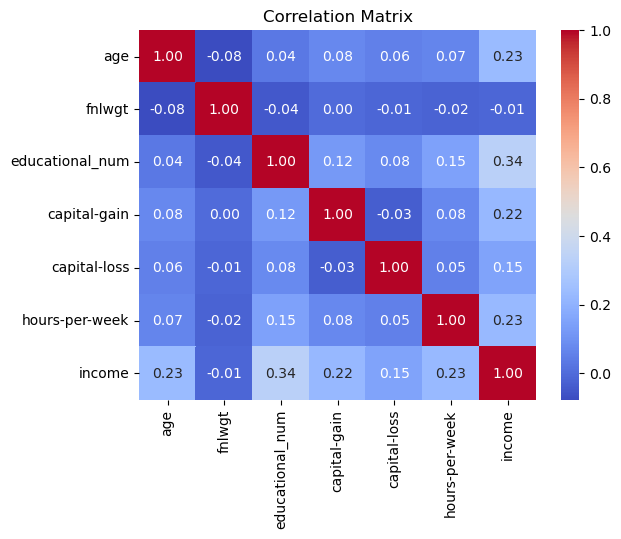

In [4]:
import seaborn as sns

# Calculate the correlation coefficient and plot the heat map
corr = df.corr()

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

As shown above, the corralation of the features are low. It seem we don't need to reduct the features. We will use the L1 regularization to select the best features later.

## Data preprocessing
Now we have become familiar with the basic characteristics of the data. Next, we can start training the model.
Before training the model a data type conversion is required to encode string type variables into numeric variables, which is done by the LabelEncoder function of the sklearn package.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder object
encoder = LabelEncoder()

for col in df:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col].astype(str))

df

,age,workclass,fnlwgt,education,educational_num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,3,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,3,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,3,201490,11,9,4,0,3,4,1,0,0,20,38,0


After the encoding is complete, all columns need to be feature scaled so that the columns are of essentially the same order of magnitude. The min-max scaling method is used here

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create MinMaxScaler object
scaler = MinMaxScaler()

# Feature scaling
for col in df.columns:
    df[col] = scaler.fit_transform(df[[col]])

df.head()

,age,workclass,fnlwgt,education,educational_num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,0.857143,0.044302,0.600000,0.800000,0.666667,0.000000,0.2,1.0,1.0,0.02174,0.0,0.397959,0.95,0.0
1,0.452055,0.714286,0.048238,0.600000,0.800000,0.333333,0.230769,0.0,1.0,1.0,0.00000,0.0,0.122449,0.95,0.0
2,0.287671,0.428571,0.138113,0.733333,0.533333,0.000000,0.384615,0.2,1.0,1.0,0.00000,0.0,0.397959,0.95,0.0
3,0.493151,0.428571,0.151068,0.066667,0.400000,0.333333,0.384615,0.0,0.5,1.0,0.00000,0.0,0.397959,0.95,0.0
4,0.150685,0.428571,0.221488,0.600000,0.800000,0.333333,0.692308,1.0,0.5,0.0,0.00000,0.0,0.397959,0.10,0.0


In [7]:
# Use the first 80% of the dataset as the training dataset and the last 20% as the valid dataset
split_idx = int(len(df) * 0.8)

df_train = df[:split_idx]
df_valid = df[split_idx:]

After data pre-processing, the model is trained using L1 regularization to find the best subset of features for the model:

In [9]:
from sklearn.linear_model import LogisticRegression

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1] 
# Instantiate the classifier and set the corresponding hyperparameters
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=0)

# Train the model using L1 regularization and select the best subset of features
clf.fit(X_train, y_train)


# Print the column names of the best feature subset
best_features = []
for i in range(len(X_train.columns)):
    if clf.coef_[0, i] != 0:
        best_features.append(X_train.columns[i]) 

best_features


['age',
 'workclass',
 'fnlwgt',
 'education',
 'educational_num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

It can be seen that the best feature subset original feature subset is consistent. So the original data can be directly used to train the model.
Next, the test set is imported and the same data transformation and feature scaling are performed to start preparing the training model

In [10]:
df_test = pd.read_csv('data/data_test.csv', header=0)

# feature transformation
for col in df_test:
    if df_test[col].dtype == 'object':
        df_test[col] = encoder.fit_transform(df_test[col].astype(str))

# feature scaled
for col in df_test.columns:
    df_test[col] = scaler.fit_transform(df_test[[col]])

## Exploring optimal hyperparameters

Training models and searching optimal hyperparameters using the keras framework:

In [11]:
from keras.models import Sequential
from keras.layers import Dense

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1] 
X_valid = df_valid.iloc[:, :-1]
y_valid = df_valid.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]


To using the Keras.tuner, we need to define a structered model. I defined a neural network model with 4 fully connected layers and BatchNormalization. The hyperparameter search space consists of the following:
	units_1~units_4: the number of neurons in each fully connected layer, taking values from 32 to 256 in steps of 32.
	dropout_1~dropout_4: the dropout rates for each layers within specific range(0.1-0.5).
	learning_rate: the learning rate of the optimizer Adam, ranging from 1e-4 to 1e-2, using logarithmic scale sampling.
In model.compile(), I use the optimizer Adam and pass it the hyperparameter learning_rate. The loss function of the model is binary_crossentropy, and the evaluation metric is AUC.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import Objective
from tensorflow.keras.layers import Dropout

# build a structured model with hyperparameters to be selected
def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu', input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_4', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC(name='auc')])

    return model

# set Keras Tuner
tuner = RandomSearch(
    build_model,
    objective=Objective('val_auc', direction='max'), 
    max_trials=20,
    directory='output',
    executions_per_trial=3,
    project_name='hyperparameter_tuning'
)

# search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), verbose=1)

# get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 20 Complete [00h 01m 59s]
val_auc: 0.9087083339691162

Best val_auc So Far: 0.9108174443244934
Total elapsed time: 00h 47m 19s
INFO:tensorflow:Oracle triggered exit


It shown that the best values of the AUC is 0.910377, and we can see the specific best hyperparameters selected during the trials.

In [13]:
best_units_1 = best_hyperparameters.get('units_1')
best_dropout_1 = best_hyperparameters.get('dropout_1')
best_units_2 = best_hyperparameters.get('units_2')
best_dropout_2 = best_hyperparameters.get('dropout_2')
best_units_3 = best_hyperparameters.get('units_3')
best_dropout_3 = best_hyperparameters.get('dropout_3')
best_units_4 = best_hyperparameters.get('units_4')
best_dropout_4 = best_hyperparameters.get('dropout_4')
best_learning_rate = best_hyperparameters.get('learning_rate')


print("Best units for Dense layer 1:", best_units_1) #224
print("Best dropout rate for Dropout layer 1:", best_dropout_1) #0.1
print("Best units for Dense layer 2:", best_units_2) # 224
print("Best dropout rate for Dropout layer 2:", best_dropout_2) # 0.5
print("Best units for Dense layer 3:", best_units_3) # 128
print("Best dropout rate for Dropout layer 3:", best_dropout_3) # 0.3
print("Best units for Dense layer 4:", best_units_4) # 64
print("Best dropout rate for Dropout layer 4:", best_dropout_4) # 0.2
print("Best learning rate for the optimizer:", best_learning_rate) # 0.0014318293848778305

Best units for Dense layer 1: 224
Best dropout rate for Dropout layer 1: 0.1
Best units for Dense layer 2: 224
Best dropout rate for Dropout layer 2: 0.5
Best units for Dense layer 3: 128
Best dropout rate for Dropout layer 3: 0.30000000000000004
Best units for Dense layer 4: 64
Best dropout rate for Dropout layer 4: 0.2
Best learning rate for the optimizer: 0.0014318293848778305


##  Implementation
Now, we can comile the model with the best hyperparameters

In [14]:
# Model construction using optimal hyperparameters
model = tuner.hypermodel.build(best_hyperparameters)

# Train the model and store the return value in the history variable
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))

# Test the model
test_loss, test_auc = model.evaluate(X_test, y_test)

print('Test AUC-ROC:', test_auc)

Epoch 1/50
407/407 [==============================] - 2s 4ms/step - loss: 0.4505 - auc: 0.8130 - val_loss: 0.3727 - val_auc: 0.8847
Epoch 2/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3684 - auc: 0.8712 - val_loss: 0.3323 - val_auc: 0.9010
Epoch 3/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3508 - auc: 0.8847 - val_loss: 0.3248 - val_auc: 0.9054
Epoch 4/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3526 - auc: 0.8830 - val_loss: 0.3322 - val_auc: 0.9018
Epoch 5/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3463 - auc: 0.8876 - val_loss: 0.3252 - val_auc: 0.9059
Epoch 6/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3445 - auc: 0.8885 - val_loss: 0.3332 - val_auc: 0.9030
Epoch 7/50
407/407 [==============================] - 1s 3ms/step - loss: 0.3416 - auc: 0.8904 - val_loss: 0.3222 - val_auc: 0.9080
Epoch 8/50
407/407 [==============================] - 1s 3ms/step - loss: 0.

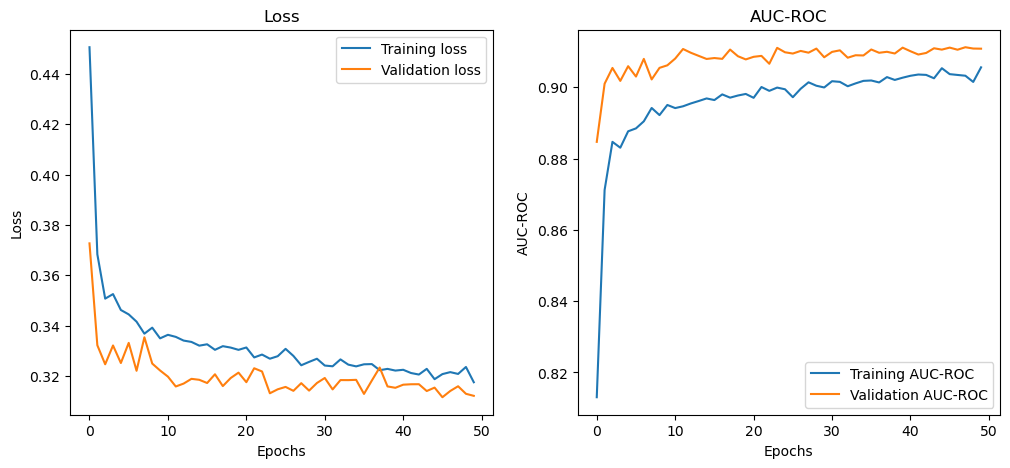

In [15]:
# Graphing Loss and AUC-ROC changes
def plot_loss_auc(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting a Loss chart
    axs[0].plot(history.history['loss'], label='Training loss')
    axs[0].plot(history.history['val_loss'], label='Validation loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting AUC-ROC charts
    axs[1].plot(history.history['auc'], label='Training AUC-ROC')
    axs[1].plot(history.history['val_auc'], label='Validation AUC-ROC')
    axs[1].set_title('AUC-ROC')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('AUC-ROC')
    axs[1].legend()

    plt.show()

# Calling plotting functions
plot_loss_auc(history)

## Evaluation of the model

Evaluate models using Run time:

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time

# Measure the runtime for predictions
start_time = time.time()
y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)
end_time = time.time()

runtime = end_time - start_time
print(f"Model prediction runtime: {runtime:.4f} seconds")

509/509 [==============================] - 1s 1ms/step
Model prediction runtime: 0.6456 seconds


Evaluate model using Accuracy, Precision, Recall and f1-score

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     12435
         1.0       0.74      0.57      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.84      0.85      0.84     16281



We can also plot the ROC-AUC value using the binary classification:

0.7553506627599242


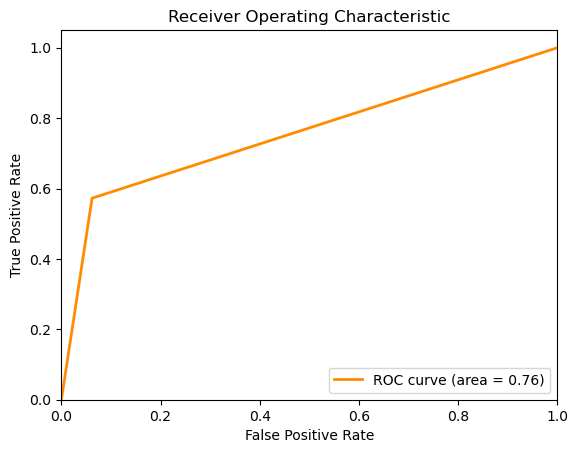

In [26]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Export the model

Export the trained model for the next step of ensemble learning

In [27]:
model

model.save('output/NeuralNetwork/NeuralNetwork.h5')

When you want to import the model, load_model.() should be used:

In [29]:
from tensorflow import keras

loaded_model = keras.models.load_model('output/NeuralNetwork/NeuralNetwork.h5')